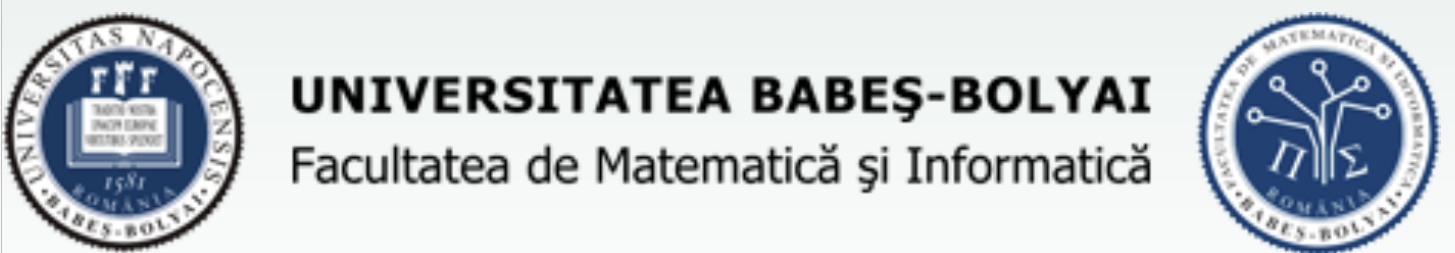

# Julia starter notebook to solve the <br/> Blood spectroscopy classification project

This is a "starter notebook" that
1. loads the data;
1. displays the basic statistics;
1. performs the transformations to make the data-set amenable for _training_


In [27]:
# reading in the data
import CSV, DataFrames

# the files from below are in the TEAMS within the FILES/DATA_PRESENTATION folder

train_data = CSV.read("Train.csv", DataFrames.DataFrame, header=true)
@info "size of the training data-set: ", size(train_data);

┌ Info: ("size of the training data-set: ", (13140, 176))
└ @ Main In[27]:7


In [28]:
tr(s::String) = (s=="ok") ? 1 : ((s=="low") ? 0 : 2)
# map(tr, String.(train_data[!,:hemoglobin_human]))
# equivalent format
ch_ldl = map(tr, String.(train_data.cholesterol_ldl_human)) # observe the different syntax of the 
ch_hdl = map(tr, String.(train_data.hdl_cholesterol_human)) # observe the different syntax of the 
ch_hgb = map(tr, String.(train_data.hemoglobin_human)) # observe the different syntax of the 
;

In [3]:
# for visualisations
import Plots
#Plots.plotly()
Plots.gr()
;

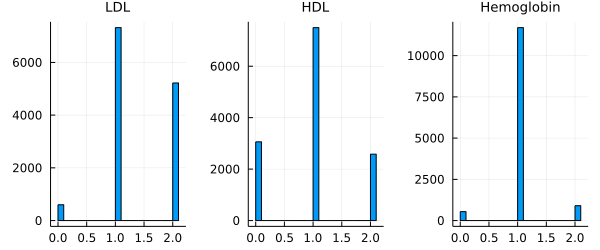

In [4]:
p = Plots.plot(layout = (1,3), size=(600,250))
Plots.histogram!(p[1],ch_ldl,legend=false,title="LDL",titlefontsize=9)
Plots.histogram!(p[2],ch_hdl,legend=false,title="HDL",titlefontsize=9)
Plots.histogram!(p[3],ch_hgb,legend=false,title="Hemoglobin",titlefontsize=9)

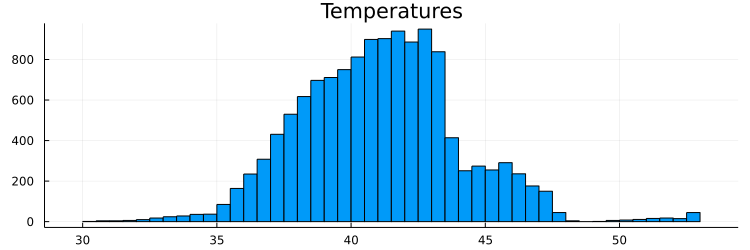

In [6]:
# plotting the temperature
p = Plots.plot( size=(750,250)) # layout = (1,3),
Plots.histogram!(p[1],train_data.temperature,legend=false,title="Temperatures")

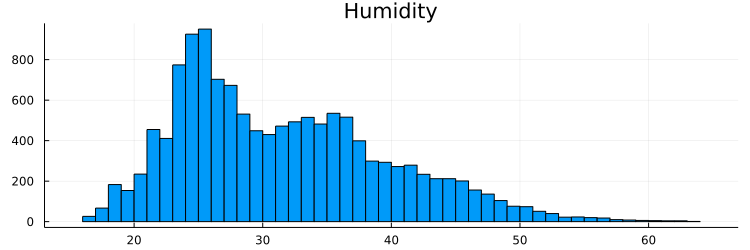

In [5]:
# plotting the humidity
p = Plots.plot( size=(750,250)) # layout = (1,3),
Plots.histogram!(p[1],train_data.humidity,legend=false,title="Humidity")

In [7]:
# plotting the temperature and humidity
p = Plots.plot( size=(900,300), layout = (1,3) )
for (i,(labels,t_str)) in
    enumerate([(ch_hdl,"HDL"),(ch_hgb,"HGB"),(ch_ldl,"LDL")])
    Plots.scatter!(p[i],Vector(train_data.temperature), Vector(train_data.humidity),
        label=false,
        title=t_str, 
        titlefontsize=11,
        xlabel = "Temperature", ylabel="Humidity", labelfontsize=9,
        markersize=2,markercolor=labels,markerstrokecolor=labels
    )
end
p # there are too many points and the rendering might get too heavy ... use with care

In [ ]:
# saving if necessary
# Plots.savefig("t.pdf")

In [11]:
# reading in the reference values
zindi_ref = CSV.read("zindi_all_ref.csv", DataFrames.DataFrame, header=true)
;

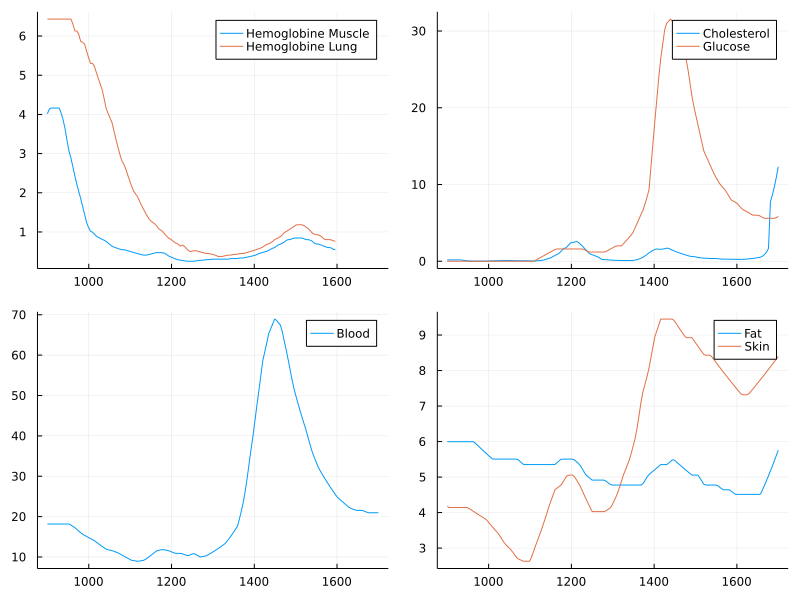

In [12]:
p = Plots.plot( size=(800,600), layout = (2,2))
Plots.plot!(p[1],zindi_ref.Wavelength,zindi_ref.Hemoglobin,label="Hemoglobine Muscle")
Plots.plot!(p[1],zindi_ref.Wavelength,zindi_ref.HemoglobinO2,label="Hemoglobine Lung")

Plots.plot!(p[2],zindi_ref.Wavelength,zindi_ref.Cholesterol,label="Cholesterol")
Plots.plot!(p[2],zindi_ref.Wavelength,zindi_ref.Glucose,label="Glucose")

Plots.plot!(p[3],zindi_ref.Wavelength,zindi_ref.Blood,label="Blood")

Plots.plot!(p[4],zindi_ref.Wavelength,zindi_ref.Fat,label="Fat")
Plots.plot!(p[4],zindi_ref.Wavelength,zindi_ref.Skin,label="Skin")

In [29]:
nTrain = size(train_data,1)
# transforming the DATAFRAME into a matrix
x_train = Matrix( train_data[!,2:171] )
# the limits are as follows: 
# first is the ID,
#  172 is the humidity, 
# 173 is the temperature
;

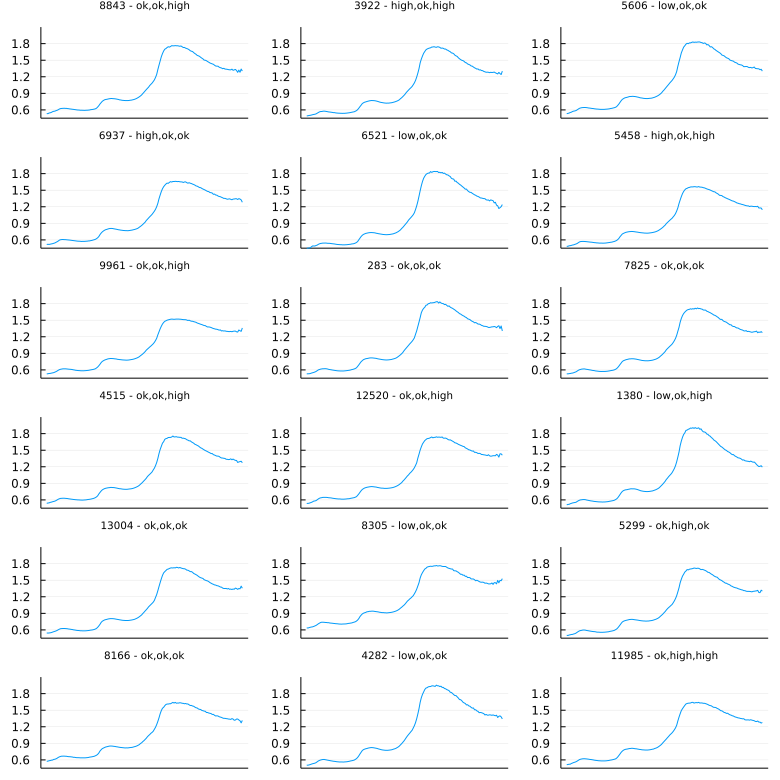

In [30]:
# plotting a few of the spectrograms
import Random

ord_p = Random.randperm(nTrain)

n_rows, n_cols = 6, 3
size_pic = 130
p = Plots.plot(layout=(n_rows,n_cols),size=size_pic .* (2*n_cols,n_rows))
for ii in 1:(n_rows*n_cols)
    Plots.plot!(p[ii],
        x_train[ord_p[ii],:],
        legend=false,
        xtick=[],#ytick=[],
        ylim=(0.45,2.1),
        title="$(ord_p[ii]) - $(train_data[ord_p[ii],174]),$(train_data[ord_p[ii],175]),$(train_data[ord_p[ii],176])",titlefontsize=7
    )
end
p

In [15]:
train_data[45,172:end]

DataFrameRow
 Row │ temperature  humidity  hdl_cholesterol_human  hemoglobin_human       ch ⋯
     │ Float64      Float64   InlineStrings.String7  InlineStrings.String7  In ⋯
─────┼──────────────────────────────────────────────────────────────────────────
  45 │       38.96     32.74  ok                     ok                     ok ⋯
                                                                1 column omitted

In [19]:
typeof(x_train)

Matrix{Float64} (alias for Array{Float64, 2})

In [20]:
size(x_train)

(13140, 170)

In [10]:
ch_ldl[45]
ch_hdl[45]
ch_hgb[45]

1

In [31]:
using Flux
using Flux: onehotbatch, argmax, crossentropy, throttle

In [32]:
y_train_ldl = onehotbatch(ch_ldl, 0:2)

3×13140 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  1  1  ⋅  1  ⋅  1  1  1  1  1  ⋅
 ⋅  1  1  1  1  ⋅  1  1  1  1  ⋅  1  1     1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1

In [156]:
y_train_hdl = onehotbatch(ch_hdl, 0:2)

3×13140 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  ⋅  1  ⋅  1  1  ⋅  1  ⋅  1  1     ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1

In [34]:
y_train_hgb = onehotbatch(ch_hgb, 0:2)

3×13140 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  1  1  1  1  1  1  1  1  1  ⋅  1     1  1  ⋅  1  1  1  1  1  1  1  1  1
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

In [35]:
using LinearAlgebra

In [36]:
x_train = transpose(x_train)

170×13140 transpose(::Matrix{Float64}) with eltype Float64:
 0.479669  0.471537  0.444998  0.513434  …  0.512718  0.456747  0.498372
 0.477423  0.474113  0.458034  0.513303     0.517815  0.472575  0.501692
 0.487956  0.479981  0.447386  0.522609     0.524857  0.466935  0.505924
 0.491831  0.485528  0.456921  0.521068     0.525466  0.466698  0.510975
 0.500516  0.491049  0.463225  0.523146     0.536542  0.478546  0.516707
 0.50259   0.497942  0.475983  0.530132  …  0.54293   0.486451  0.520821
 0.511561  0.50476   0.476817  0.539517     0.550628  0.494838  0.531242
 0.514639  0.510543  0.481565  0.546364     0.558939  0.49654   0.537302
 0.524245  0.522328  0.49001   0.552414     0.567593  0.508274  0.547303
 0.53617   0.534423  0.505892  0.565502     0.579192  0.521304  0.563789
 0.546407  0.548646  0.518125  0.581143  …  0.595752  0.532652  0.574825
 0.561557  0.55842   0.530362  0.594354     0.609749  0.542257  0.585327
 0.568417  0.565449  0.53853   0.599457     0.617717  0.550854  

In [59]:
size(x_train)

(170, 13140)

In [38]:
m_ldl = Chain(
    Dense(170, 32, relu),
    Dense(32, 3),
    softmax)

Chain(
  Dense(170, 32, relu),                 # 5_472 parameters
  Dense(32, 3),                         # 99 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 5_571 parameters, 22.012 KiB.

In [171]:
m_hdl = Chain(
    Dense(170, 32, relu),
    Dense(32, 3),
    softmax)

Chain(
  Dense(170, 32, relu),                 # 5_472 parameters
  Dense(32, 3),                         # 99 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 5_571 parameters, 22.012 KiB.

In [40]:
m_hgb = Chain(
    Dense(170, 32, relu),
    Dense(32, 3),
    softmax)

Chain(
  Dense(170, 32, relu),                 # 5_472 parameters
  Dense(32, 3),                         # 99 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 5_571 parameters, 22.012 KiB.

In [141]:
x_train = Matrix(x_train)

170×13140 Matrix{Float64}:
 0.479669  0.471537  0.444998  0.513434  …  0.512718  0.456747  0.498372
 0.477423  0.474113  0.458034  0.513303     0.517815  0.472575  0.501692
 0.487956  0.479981  0.447386  0.522609     0.524857  0.466935  0.505924
 0.491831  0.485528  0.456921  0.521068     0.525466  0.466698  0.510975
 0.500516  0.491049  0.463225  0.523146     0.536542  0.478546  0.516707
 0.50259   0.497942  0.475983  0.530132  …  0.54293   0.486451  0.520821
 0.511561  0.50476   0.476817  0.539517     0.550628  0.494838  0.531242
 0.514639  0.510543  0.481565  0.546364     0.558939  0.49654   0.537302
 0.524245  0.522328  0.49001   0.552414     0.567593  0.508274  0.547303
 0.53617   0.534423  0.505892  0.565502     0.579192  0.521304  0.563789
 0.546407  0.548646  0.518125  0.581143  …  0.595752  0.532652  0.574825
 0.561557  0.55842   0.530362  0.594354     0.609749  0.542257  0.585327
 0.568417  0.565449  0.53853   0.599457     0.617717  0.550854  0.588966
 ⋮                      

In [181]:
using Base.Iterators: repeated
datasetx_ldl = repeated((x_train, y_train_ldl), 1000)
C_ldl = collect(datasetx_ldl);
evalcb_ldl = () -> @show(loss(x_train,y_train_ldl))
ps_ldl = Flux.params(m_ldl)

datasetx_hdl = repeated((x_train, y_train_hdl), 1000)
C_hdl = collect(datasetx_hdl);
evalcb_hdl = () -> @show(loss(x_train,y_train_hdl))
ps_hdl = Flux.params(m_hdl)

datasetx_hgb = repeated((x_train, y_train_hgb), 1000)
C_hgb = collect(datasetx_hgb);
evalcb_hgb = () -> @show(loss(x_train,y_train_hgb))
ps_hgb = Flux.params(m_hgb)

opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [187]:
loss(x, y) = Flux.crossentropy(m_hdl(x), y)
Flux.train!(loss, ps_hdl, datasetx_hdl, opt, cb = throttle(evalcb_hdl, 15))

loss(x_train, y_train_hdl) = 0.9414810327693336
loss(x_train, y_train_hdl) = 0.9401978386684222
loss(x_train, y_train_hdl) = 0.9413407354439832
loss(x_train, y_train_hdl) = 0.935549580574974
loss(x_train, y_train_hdl) = 0.9340911937796094
loss(x_train, y_train_hdl) = 0.932565172360568


In [188]:
argmax(m_hdl(x_train[:,40])) - 1

1

In [189]:
argmax(y_train_hdl[:,40]) - 1

2

In [190]:
ch_hdl[40]

2

In [191]:
cont = 0
for i in 1:13140
    cont = cont + (argmax(m_hdl(x_train[:,i])) == argmax(y_train_hdl[:,i]) )
end
cont / 13140

0.5723744292237443

In [192]:
loss(x, y) = Flux.crossentropy(m_ldl(x), y)
Flux.train!(loss, ps_ldl, datasetx_ldl, opt, cb = throttle(evalcb_ldl, 15))

loss(x_train, y_train_ldl) = 2.4283572458967373
loss(x_train, y_train_ldl) = 0.8323259242528258
loss(x_train, y_train_ldl) = 0.8314336664025794
loss(x_train, y_train_ldl) = 0.8304830694917354
loss(x_train, y_train_ldl) = 0.8295303174712758
loss(x_train, y_train_ldl) = 0.8285660618622992


In [193]:
argmax(m_ldl(x_train[:,40])) - 1

1

In [194]:
argmax(y_train_ldl[:,40]) - 1

2

In [197]:
ch_ldl[40]

2

In [198]:
cont = 0
for i in 1:13140
    cont = cont + (argmax(m_ldl(x_train[:,i])) == argmax(y_train_ldl[:,i]) )
end
cont / 13140

0.5627853881278538

In [199]:
loss(x, y) = Flux.crossentropy(m_hgb(x), y)
Flux.train!(loss, ps_hgb, datasetx_hgb, opt, cb = throttle(evalcb_hgb, 15))

loss(x_train, y_train_hgb) = 0.561121322573444
loss(x_train, y_train_hgb) = 0.4215149006395994
loss(x_train, y_train_hgb) = 0.4202012846189897
loss(x_train, y_train_hgb) = 0.41890698672381144
loss(x_train, y_train_hgb) = 0.41776163807905686
loss(x_train, y_train_hgb) = 0.4167649988921307


In [200]:
argmax(m_hgb(x_train[:,40])) - 1

1

In [201]:
argmax(y_train_hgb[:,40]) - 1

1

In [202]:
ch_hgb[40]

1

In [203]:
cont = 0
for i in 1:13140
    cont = cont + (argmax(m_hgb(x_train[:,i])) == argmax(y_train_hgb[:,i]) )
end
cont / 13140

0.8904109589041096

In [204]:
test_data = CSV.read("Updated_Test.csv", DataFrames.DataFrame, header=true)
@info "size of the testing data-set: ", size(test_data);

┌ Info: ("size of the testing data-set: ", (3660, 176))
└ @ Main In[204]:2


In [205]:
x_test = Matrix( test_data[!,3:172] )

3660×170 Matrix{Float64}:
 0.517951  0.520508  0.526852  …  1.21442  1.20033  1.1983   1.24818
 0.517839  0.522367  0.525186     1.19142  1.20252  1.21194  1.24294
 0.517702  0.522018  0.527237     1.20872  1.18781  1.2096   1.17563
 0.525008  0.527439  0.536871     1.19675  1.22248  1.17741  1.1984
 0.520532  0.522683  0.526842     1.20331  1.19135  1.15758  1.21201
 0.526705  0.532114  0.53673   …  1.20564  1.20997  1.18962  1.25187
 0.52087   0.531424  0.534101     1.22859  1.21229  1.18651  1.24754
 0.5272    0.525328  0.532838     1.2113   1.19753  1.18407  1.22911
 0.52583   0.532805  0.53567      1.23785  1.2202   1.21595  1.1808
 0.533108  0.530202  0.537924     1.19754  1.21006  1.21042  1.22333
 0.520832  0.520129  0.529437  …  1.20865  1.20913  1.20634  1.22758
 0.527607  0.526316  0.52909      1.23589  1.18447  1.20081  1.20212
 0.516474  0.523206  0.528554     1.18783  1.19251  1.20299  1.24579
 ⋮                             ⋱                             
 0.510119  0.5091

In [206]:
x_test = transpose(x_test)

170×3660 transpose(::Matrix{Float64}) with eltype Float64:
 0.517951  0.517839  0.517702  0.525008  …  0.504268  0.508112  0.519984
 0.520508  0.522367  0.522018  0.527439     0.498534  0.508622  0.523291
 0.526852  0.525186  0.527237  0.536871     0.504383  0.511373  0.522272
 0.531611  0.534661  0.534374  0.539636     0.506042  0.516235  0.52476
 0.536816  0.5419    0.541155  0.546555     0.51465   0.523375  0.529858
 0.543828  0.54618   0.547152  0.553183  …  0.522117  0.529093  0.541437
 0.547761  0.551687  0.549837  0.558826     0.528692  0.536244  0.547259
 0.554379  0.556753  0.557513  0.563549     0.533725  0.540203  0.553041
 0.565622  0.566446  0.566793  0.575675     0.544288  0.550041  0.56298
 0.575762  0.578208  0.580574  0.587214     0.555969  0.563505  0.574798
 0.590253  0.591039  0.592258  0.597155  …  0.573758  0.58063   0.591095
 0.600692  0.60162   0.601226  0.606784     0.58665   0.592105  0.602305
 0.605104  0.605895  0.608085  0.612443     0.593866  0.600402  0.6

In [208]:
hdl_test = m_hdl(x_test)

3×3660 Matrix{Float64}:
 0.366255  0.364104  0.358019  0.350841  …  0.163756  0.169817  0.187357
 0.513803  0.515756  0.519456  0.524923     0.67019   0.669565  0.666575
 0.119943  0.12014   0.122525  0.124237     0.166054  0.160618  0.146068

In [210]:
ldl_test = m_ldl(x_test)

3×3660 Matrix{Float64}:
 0.0538423  0.0533691  0.0531077  …  0.0431534  0.0449235  0.0431316
 0.523158   0.522793   0.528022      0.565863   0.559856   0.568109
 0.423      0.423838   0.41887       0.390984   0.39522    0.388759

In [211]:
hgb_test = m_hgb(x_test)

3×3660 Matrix{Float64}:
 0.0337524  0.0333456  0.0335029  …  0.0452752  0.0429215  0.0418155
 0.881837   0.882949   0.884231      0.884408   0.883056   0.889591
 0.0844102  0.0837057  0.0822665     0.070317   0.0740227  0.0685934

In [225]:
function label(x)
    (argmax(x) - 1 == 0) ? "low" : ((argmax(x) - 1 == 1) ? "ok" : "high")
end

for i in 1:3660
    print(test_data[i,2])
    print(" ")
    print(label(hgb_test[:,i]))
    println(" ")
end

ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_2982 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5730 ok 
ID_5

ID_2827 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_2155 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6381 ok 
ID_6

ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_2770 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4172 ok 
ID_4

ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_2436 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6391 ok 
ID_6

In [229]:
unique(test_data.donation_id)

61-element Vector{InlineStrings.String7}:
 "ID_2982"
 "ID_5730"
 "ID_2517"
 "ID_3212"
 "ID_2495"
 "ID_5151"
 "ID_2551"
 "ID_2524"
 "ID_2067"
 "ID_3635"
 "ID_2819"
 "ID_7821"
 "ID_6373"
 ⋮
 "ID_2557"
 "ID_2436"
 "ID_6391"
 "ID_1961"
 "ID_3811"
 "ID_3497"
 "ID_3689"
 "ID_5243"
 "ID_3688"
 "ID_3594"
 "ID_2441"
 "ID_3637"

In [233]:
train_data.hdl_cholesterol_human

3×13140 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  1  1  ⋅  1  ⋅  1  1  ⋅  1  ⋅  1  1     ⋅  ⋅  1  1  1  1  1  ⋅  1  1  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1

In [240]:
using DataFrames
combine(groupby(train_data, [:hdl_cholesterol_human]), nrow => :count)

3×2 DataFrame
 Row │ hdl_cholesterol_human  count 
     │ InlineStrings.String7  Int64 
─────┼──────────────────────────────
   1 │ ok                      7500
   2 │ low                     3060
   3 │ high                    2580

In [255]:
x_train_low = transpose(Matrix( train_data[train_data.hdl_cholesterol_human .== "low", 2:171] ))

170×3060 transpose(::Matrix{Float64}) with eltype Float64:
 0.513434  0.547021  0.476799  0.533322  …  0.489653  0.500695  0.454706
 0.513303  0.553422  0.481452  0.539424     0.48872   0.505005  0.454505
 0.522609  0.563921  0.483358  0.545329     0.494578  0.50952   0.461361
 0.521068  0.567715  0.490046  0.546416     0.498835  0.517742  0.463831
 0.523146  0.579869  0.491382  0.558224     0.502953  0.528813  0.471723
 0.530132  0.590251  0.500921  0.561411  …  0.51133   0.531519  0.474386
 0.539517  0.595393  0.506735  0.567811     0.517013  0.53674   0.483258
 0.546364  0.597208  0.512667  0.572183     0.523499  0.539252  0.486905
 0.552414  0.604721  0.521872  0.581994     0.532938  0.546072  0.492968
 0.565502  0.613363  0.5346    0.593428     0.544329  0.559832  0.503599
 0.581143  0.629891  0.545943  0.603944  …  0.558247  0.571211  0.513133
 0.594354  0.637479  0.556446  0.614319     0.57382   0.580637  0.524824
 0.599457  0.646378  0.560816  0.619232     0.581687  0.587903  0

In [256]:
x_train_low = [x_train_low x_train_low]

170×6120 Matrix{Float64}:
 0.513434  0.547021  0.476799  0.533322  …  0.489653  0.500695  0.454706
 0.513303  0.553422  0.481452  0.539424     0.48872   0.505005  0.454505
 0.522609  0.563921  0.483358  0.545329     0.494578  0.50952   0.461361
 0.521068  0.567715  0.490046  0.546416     0.498835  0.517742  0.463831
 0.523146  0.579869  0.491382  0.558224     0.502953  0.528813  0.471723
 0.530132  0.590251  0.500921  0.561411  …  0.51133   0.531519  0.474386
 0.539517  0.595393  0.506735  0.567811     0.517013  0.53674   0.483258
 0.546364  0.597208  0.512667  0.572183     0.523499  0.539252  0.486905
 0.552414  0.604721  0.521872  0.581994     0.532938  0.546072  0.492968
 0.565502  0.613363  0.5346    0.593428     0.544329  0.559832  0.503599
 0.581143  0.629891  0.545943  0.603944  …  0.558247  0.571211  0.513133
 0.594354  0.637479  0.556446  0.614319     0.57382   0.580637  0.524824
 0.599457  0.646378  0.560816  0.619232     0.581687  0.587903  0.533123
 ⋮                       

In [269]:
new_train_data = copy(train_data)

13160×176 DataFrame
   Row │ Reading_ID   absorbance0  absorbance1  absorbance2  absorbance3  abso ⋯
       │ String15     Float64      Float64      Float64      Float64      Floa ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ ID_3SSHI56C     0.479669     0.477423     0.487956     0.491831     0 ⋯
     2 │ ID_599OOLZA     0.471537     0.474113     0.479981     0.485528     0
     3 │ ID_MVJGPQ75     0.444998     0.458034     0.447386     0.456921     0
     4 │ ID_CK6RF8YV     0.513434     0.513303     0.522609     0.521068     0
     5 │ ID_82N6QE6I     0.510485     0.519359     0.524225     0.528419     0 ⋯
     6 │ ID_3LCCBJVO     0.547021     0.553422     0.563921     0.567715     0
     7 │ ID_4TK4WAI7     0.517956     0.522156     0.529304     0.544396     0
     8 │ ID_JH3G89RM     0.497032     0.495025     0.494494     0.503662     0
     9 │ ID_2PF9JK4O     0.476799     0.481452     0.483358     0.490046     0 ⋯
    10 │ ID_TG56LKBY     0.501158     0.511572     0.513042     0.520507     0
    11 │ ID_T1DP1ZHA     0.533322     0.539424     0.545329     0.546416     0
   ⋮   │      ⋮            ⋮            ⋮            ⋮            ⋮            ⋱
 13151 │ ID_3SSHI56C     0.479669     0.477423     0.487956     0.491831     0
 13152 │ ID_599OOLZA     0.471537     0.474113     0.479981     0.485528     0 ⋯
 13153 │ ID_MVJGPQ75     0.444998     0.458034     0.447386     0.456921     0
 13154 │ ID_CK6RF8YV     0.513434     0.513303     0.522609     0.521068     0
 13155 │ ID_82N6QE6I     0.510485     0.519359     0.524225     0.528419     0
 13156 │ ID_3LCCBJVO     0.547021     0.553422     0.563921     0.567715     0 ⋯
 13157 │ ID_4TK4WAI7     0.517956     0.522156     0.529304     0.544396     0
 13158 │ ID_JH3G89RM     0.497032     0.495025     0.494494     0.503662     0
 13159 │ ID_2PF9JK4O     0.476799     0.481452     0.483358     0.490046     0
 13160 │ ID_TG56LKBY     0.501158     0.511572     0.513042     0.520507     0 ⋯
                                              171 columns and 13139 rows omitted

In [270]:
for i in 1:10
    push!(new_train_data, train_data[i,:])
end

In [272]:
new_train_data

13170×176 DataFrame
   Row │ Reading_ID   absorbance0  absorbance1  absorbance2  absorbance3  abso ⋯
       │ String15     Float64      Float64      Float64      Float64      Floa ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ ID_3SSHI56C     0.479669     0.477423     0.487956     0.491831     0 ⋯
     2 │ ID_599OOLZA     0.471537     0.474113     0.479981     0.485528     0
     3 │ ID_MVJGPQ75     0.444998     0.458034     0.447386     0.456921     0
     4 │ ID_CK6RF8YV     0.513434     0.513303     0.522609     0.521068     0
     5 │ ID_82N6QE6I     0.510485     0.519359     0.524225     0.528419     0 ⋯
     6 │ ID_3LCCBJVO     0.547021     0.553422     0.563921     0.567715     0
     7 │ ID_4TK4WAI7     0.517956     0.522156     0.529304     0.544396     0
     8 │ ID_JH3G89RM     0.497032     0.495025     0.494494     0.503662     0
     9 │ ID_2PF9JK4O     0.476799     0.481452     0.483358     0.490046     0 ⋯
    10 │ ID_TG56LKBY     0.501158     0.511572     0.513042     0.520507     0
    11 │ ID_T1DP1ZHA     0.533322     0.539424     0.545329     0.546416     0
   ⋮   │      ⋮            ⋮            ⋮            ⋮            ⋮            ⋱
 13161 │ ID_3SSHI56C     0.479669     0.477423     0.487956     0.491831     0
 13162 │ ID_599OOLZA     0.471537     0.474113     0.479981     0.485528     0 ⋯
 13163 │ ID_MVJGPQ75     0.444998     0.458034     0.447386     0.456921     0
 13164 │ ID_CK6RF8YV     0.513434     0.513303     0.522609     0.521068     0
 13165 │ ID_82N6QE6I     0.510485     0.519359     0.524225     0.528419     0
 13166 │ ID_3LCCBJVO     0.547021     0.553422     0.563921     0.567715     0 ⋯
 13167 │ ID_4TK4WAI7     0.517956     0.522156     0.529304     0.544396     0
 13168 │ ID_JH3G89RM     0.497032     0.495025     0.494494     0.503662     0
 13169 │ ID_2PF9JK4O     0.476799     0.481452     0.483358     0.490046     0
 13170 │ ID_TG56LKBY     0.501158     0.511572     0.513042     0.520507     0 ⋯
                                              171 columns and 13149 rows omitted

In [273]:
using Random
new_train_data[randperm(nrow(new_train_data)), :]

13170×176 DataFrame
   Row │ Reading_ID   absorbance0  absorbance1  absorbance2  absorbance3  abso ⋯
       │ String15     Float64      Float64      Float64      Float64      Floa ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ ID_YA3BGMHF     0.640271     0.638426     0.648402     0.655379     0 ⋯
     2 │ ID_AG3JKPKX     0.607338     0.605892     0.61496      0.61677      0
     3 │ ID_O4DNYFR2     0.480419     0.481128     0.488654     0.490883     0
     4 │ ID_L0T7WXYW     0.4767       0.482615     0.485742     0.485661     0
     5 │ ID_63TMCNU2     0.528809     0.530653     0.536237     0.548046     0 ⋯
     6 │ ID_K0YL0GRZ     0.527496     0.526761     0.530232     0.537132     0
     7 │ ID_GJL2Q7X5     0.490842     0.492661     0.494466     0.496657     0
     8 │ ID_V3C4TQZ2     0.52455      0.526412     0.529103     0.538459     0
     9 │ ID_QG8DW81P     0.558444     0.561981     0.563444     0.569295     0 ⋯
    10 │ ID_ZI5RE7P4     0.508948     0.515819     0.516802     0.522397     0
    11 │ ID_Q3HNU8YF     0.505907     0.509087     0.51192      0.522967     0
   ⋮   │      ⋮            ⋮            ⋮            ⋮            ⋮            ⋱
 13161 │ ID_MZF86TCR     0.557752     0.56504      0.575094     0.574585     0
 13162 │ ID_ER6CKPKK     0.496259     0.488824     0.498318     0.504412     0 ⋯
 13163 │ ID_DYQ4AL6E     0.54744      0.546485     0.552667     0.55458      0
 13164 │ ID_9LSA03FC     0.509367     0.514554     0.515737     0.521956     0
 13165 │ ID_TVI6RU3K     0.494108     0.491879     0.500906     0.505243     0
 13166 │ ID_MZSQQETF     0.523845     0.531901     0.533523     0.54737      0 ⋯
 13167 │ ID_XT7QFITB     0.512664     0.51188      0.518994     0.525836     0
 13168 │ ID_PHLILXJI     0.523887     0.526556     0.533375     0.538687     0
 13169 │ ID_MNYGN0TC     0.536255     0.539201     0.540519     0.546365     0
 13170 │ ID_1T49640K     0.505337     0.506215     0.513908     0.521702     0 ⋯
                                              171 columns and 13149 rows omitted